In [ ]:
import pandas as pd
from datetime import datetime

def convert_to_iso8601_safe(timestamp_str):
    try:
        # Parsing the given timestamp format
        dt = datetime.strptime(timestamp_str, '%a, %d %b %Y %H:%M:%S GMT')
        # Converting to ISO 8601 format with 'Z' indicating UTC timezone
        return dt.isoformat() + 'Z'
    except (TypeError, ValueError):
        # Return the original string if conversion fails
        return timestamp_str

def convert_csv_timestamps(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)

    # List of timestamp columns to convert
    timestamp_columns = ['connectionTime', 'disconnectTime', 'doneChargingTime']

    # Applying the conversion to each column
    for column in timestamp_columns:
        data[column] = data[column].apply(convert_to_iso8601_safe)

    # Save the updated dataframe back to CSV
    output_file_path = 'updated_' + file_path
    data.to_csv(output_file_path, index=False)


    return output_file_path

# Path to your CSV file
file_path = 'train.csv'

# Call the function with your file path
updated_file_path = convert_csv_timestamps(file_path)

print(f"Updated CSV file saved to: {updated_file_path}")

Updated CSV file saved to: updated_train.csv


In [ ]:
def add_end_time_column(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Convert 'disconnectTime' and 'doneChargingTime' to datetime format
    data['disconnectTime'] = pd.to_datetime(data['disconnectTime'], errors='coerce', format='%Y-%m-%dT%H:%M:%SZ')
    data['doneChargingTime'] = pd.to_datetime(data['doneChargingTime'], errors='coerce', format='%Y-%m-%dT%H:%M:%SZ')

    # Create a new column 'endTime' with the minimum of 'disconnectTime' and 'doneChargingTime'
    data['endTime'] = data[['disconnectTime', 'doneChargingTime']].min(axis=1)

    # Save the updated dataframe back to a new CSV
    output_file_path = 'train2.csv'
    data.to_csv(output_file_path, index=False)

    return output_file_path

# Path to your updated CSV file
updated_file_path = 'updated_train.csv'

# Call the function with your updated file path
final_file_path = add_end_time_column(updated_file_path)

print(f"Final CSV file with 'endTime' column saved to: {final_file_path}")

Final CSV file with 'endTime' column saved to: train2.csv


In [ ]:

def calculate_time_difference(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Convert 'endTime' to datetime format (assuming 'endTime' is in 'YYYY-MM-DD HH:MM:SS' format)
    data['endTime'] = pd.to_datetime(data['endTime'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

    # Convert 'connectionTime' to datetime format and remove timezone (making it timezone-naive)
    data['connectionTime'] = pd.to_datetime(data['connectionTime'], errors='coerce').dt.tz_localize(None)

    # Calculate the difference and store it in 'diffTime' column
    data['diffTime'] = data['endTime'] - data['connectionTime']

    # Convert 'diffTime' to total seconds for a numerical representation
    data['diffTime'] = data['diffTime'].dt.total_seconds()

    # Save the updated dataframe back to a new CSV
    output_file_path = 'train3.csv'
    data.to_csv(output_file_path, index=False)

    return output_file_path

# Path to your file
file_path = 'train2.csv'

# Call the function with your file path
final_file_path = calculate_time_difference(file_path)

print(f"Final CSV file with 'diffTime' column saved to: {final_file_path}")


Final CSV file with 'diffTime' column saved to: train3.csv


In [ ]:
df = pd.read_csv('train3.csv')

# Check if 'kWh' and 'diffTime' columns exist
if 'kWhDelivered' in df.columns and 'diffTime' in df.columns:
    # Convert 'diffTime' from seconds to hours
    df['diffTime'] = df['diffTime'] / 3600

    # Calculate 'Power dispensed'
    df['Power dispensed'] = df['kWhDelivered']

    # Save the modified DataFrame to a new CSV file
    df.to_csv('train4.csv', index=False)

    print("The 'Power dispensed' column has been added and the modified DataFrame is saved.")
else:
    print("Please ensure your CSV file contains 'kWh' and 'diffTime' columns.")

The 'Power dispensed' column has been added and the modified DataFrame is saved.


In [ ]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('train4.csv', parse_dates=['connectionTime', 'endTime'])

# Convert 'Power dispensed' from kWh to kW-seconds by multiplying by 3600
df['Power dispensed'] *= 3600

# Extract date from min connection time and max end time
min_date = df['connectionTime'].min().date()
max_date = pd.Timestamp(df['endTime'].dt.year.max(), 12, 31, 23)

# Combine date with start and end times
start_time = pd.Timestamp(min_date).normalize()
end_time = pd.Timestamp(max_date).normalize() + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)  # Add one day and subtract one second to get 23:59:59 of the max date

# Generate time index with frequency of one second
time_index = pd.date_range(start=start_time, end=end_time, freq='S')
time_df = pd.DataFrame(index=time_index, columns=['Power dispensed']).fillna(0)

# Iterate over each row to fill in the 'Power dispensed' for each second in its range
for _, row in df.iterrows():
    # Ensure there's at least a 1-second range
    if row['connectionTime'] == row['endTime']:
        continue  # Skip this row
    time_range = pd.date_range(start=row['connectionTime'], end=row['endTime'], freq='S')
    if len(time_range) > 0:
        time_df.loc[time_range, 'Power dispensed'] += row['Power dispensed'] / len(time_range)

# Now aggregate this data into hourly buckets ('OP1' and 'OP2')
# 'OP1' will be the hourly buckets, 'OP2' will be the sum of power dispensed in that hour, converted back to kWh
result_df = time_df.resample('H').sum()
result_df['Power dispensed'] = result_df['Power dispensed'] / 3600  # Convert back to kWh
# result_df['id'] = np.arange(1, len(result_df) + 1)
result_df.rename(columns={'Power dispensed': 'power'}, inplace=True)

# Add 'time' column
result_df.reset_index(inplace=True)
result_df.rename(columns={'index': 'time'}, inplace=True)

# Saving the result
result_df.to_csv('result.csv', index=False)

print("Hourly bucket data saved to 'result.csv'.")


Hourly bucket data saved to 'result.csv'.


In [ ]:
december_df = result_df[result_df['time'].dt.month == 12]

print(december_df)

                    time   power
8040 2020-12-01 00:00:00   0.000
8041 2020-12-01 01:00:00   0.000
8042 2020-12-01 02:00:00  21.032
8043 2020-12-01 03:00:00   0.000
8044 2020-12-01 04:00:00   7.104
...                  ...     ...
8779 2020-12-31 19:00:00   0.000
8780 2020-12-31 20:00:00   0.000
8781 2020-12-31 21:00:00   0.000
8782 2020-12-31 22:00:00   0.000
8783 2020-12-31 23:00:00   0.000

[744 rows x 2 columns]


In [ ]:
import pandas as pd

# # Assuming 'time' column is in datetime format

# # Filtering out rows where the month is 12
# result_df = result_df[result_df['month'] != 12]
result_df = result_df[result_df['power'] != 0]

print(result_df)

                    time      power
9    2020-01-01 09:00:00   1.896506
10   2020-01-01 10:00:00   6.404712
11   2020-01-01 11:00:00   6.404712
12   2020-01-01 12:00:00   6.404712
13   2020-01-01 13:00:00   6.404712
...                  ...        ...
8037 2020-11-30 21:00:00   0.163362
8038 2020-11-30 22:00:00   1.004076
8039 2020-11-30 23:00:00   1.348869
8042 2020-12-01 02:00:00  21.032000
8044 2020-12-01 04:00:00   7.104000

[1950 rows x 2 columns]


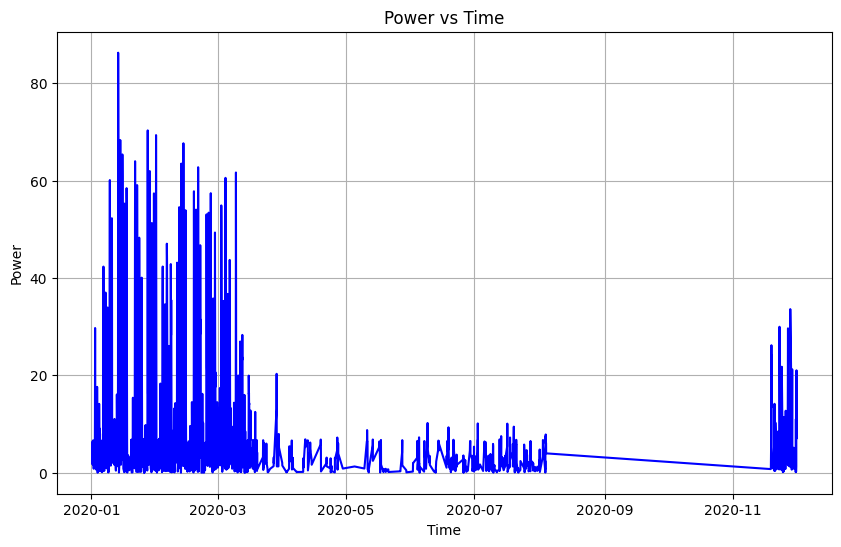

In [ ]:
import matplotlib.pyplot as plt

# Plotting the 'time' against 'power'
plt.figure(figsize=(10, 6))
plt.plot(result_df['time'], result_df['power'], color='blue')
plt.title('Power vs Time')
plt.xlabel('Time')
plt.ylabel('Power')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Load the data
data = result_df.copy(deep = True)

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Filter data for December
# december_data = data[data['month'] == 12]

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(data[features], data[target])

# Predict kWh consumed for each hour of December
december_hours = []
for day in range(1, 32):  # Assuming December has 31 days
    for hour in range(24):  # 24 hours in a day
        december_hours.append([12, day, hour])

december_predictions = model.predict(december_hours)

december_predictions_df = pd.DataFrame({'Row ID': range(1, len(december_predictions) + 1), 'Predicted': december_predictions})
december_predictions_df.to_csv('december_predictions.csv', index=False)


print("December predictions saved to 'december_predictions.csv'.")


December predictions saved to 'december_predictions.csv'.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


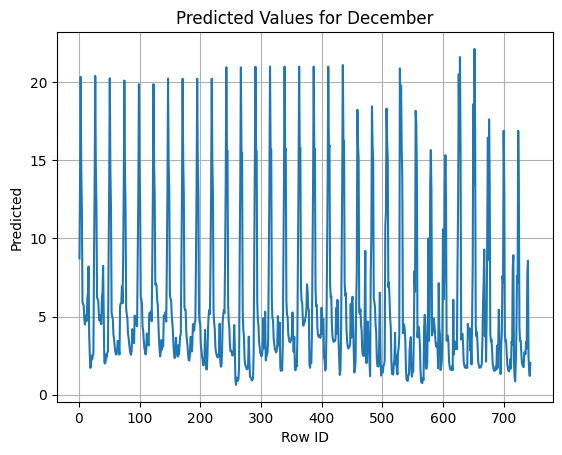

In [ ]:
import matplotlib.pyplot as plt

# Plotting the line graph
plt.plot(december_predictions_df['Row ID'], december_predictions_df['Predicted'])
plt.xlabel('Row ID')
plt.ylabel('Predicted')
plt.title('Predicted Values for December')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# Load the data
data = result_df.copy(deep=True)

# Shuffle the data
data = data.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Split data into train and test sets
train_data = data

# Define preprocessing steps for numerical features
numeric_features = ['month', 'day', 'hour']
numeric_transformer = StandardScaler()

# Combine preprocessing steps for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Initialize GBM model within a pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())  # GBM model
])

# Adjusting hyperparameters for better performance
param_grid = {
    'regressor__n_estimators': [100, 200, 300],  # Increase the number of boosting stages
    'regressor__learning_rate': [0.01, 0.05, 0.1],  # Adjust the step size shrinkage
    'regressor__max_depth': [5, 8, 10]  # Adjust the maximum depth of the individual regression estimators
}

# Perform Grid Search Cross Validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(train_data[features], train_data[target])

# Get the best model from grid search
best_model = grid_search.best_estimator_

# # Make predictions on the test set
# predictions = best_model.predict(test_data[features])

# # Calculate Mean Absolute Error (MAE) on the test set
# mae = mean_absolute_error(test_data[target], predictions)
# print("Mean Absolute Error (MAE) on the test set:", mae)

# Predict kWh consumed for each hour of December
december_hours = []
for day in range(1, 32):  # Assuming December has 31 days
    for hour in range(24):  # 24 hours in a day
        december_hours.append([12, day, hour])

# Convert December hours to DataFrame
december_hours_df = pd.DataFrame(december_hours, columns=['month', 'day', 'hour'])

# Make predictions for December hours
december_predictions = best_model.predict(december_hours_df)

# Create DataFrame for December predictions
december_predictions_df = pd.DataFrame({'Row ID': range(1, len(december_predictions) + 1), 'Predicted': december_predictions})

# Save predictions to CSV file
december_predictions_df.to_csv('december_predictions.csv', index=False)

print("December predictions saved to 'december_predictions.csv'.")


December predictions saved to 'december_predictions.csv'.


In [ ]:

from prophet import Prophet  # Import Prophet


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# Load the data
data = result_df.copy(deep=True)

# # Shuffle the data
# data = data.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Choose one particular month (except December) for testing
test_month = 1  # For example, October

for test_month in range(8):
  if data[data['month'] == test_month].empty:
      print("No data available for the specified testing month.")
  else:
      # Split data into train and test sets
      train_data = data[data['month'] != test_month]
      test_data = data[data['month'] == test_month]

      # Define preprocessing steps for numerical features
      numeric_features = ['month', 'day', 'hour']
      numeric_transformer = StandardScaler()

      # Combine preprocessing steps for all features
      preprocessor = ColumnTransformer(
          transformers=[
              ('num', numeric_transformer, numeric_features)
          ])

      # Initialize GBM model within a pipeline
      model = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('regressor', GradientBoostingRegressor())  # GBM model
      ])

      # Adjusting hyperparameters for better performance
      param_grid = {
          'regressor__n_estimators': [100, 200, 300],  # Increase the number of boosting stages
          'regressor__learning_rate': [0.01, 0.05, 0.1],  # Adjust the step size shrinkage
          'regressor__max_depth': [5, 8, 10]  # Adjust the maximum depth of the individual regression estimators
      }

      # Perform Grid Search Cross Validation to find the best hyperparameters
      grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
      grid_search.fit(train_data[features], train_data[target])

      # Get the best model from grid search
      best_model = grid_search.best_estimator_

      # Make predictions on the test set if it's not empty
      predictions = best_model.predict(test_data[features])

      # Calculate Mean Absolute Error (MAE) on the test set
      mae = mean_absolute_error(test_data[target], predictions)
      print("Mean Absolute Error (MAE) on the test set month:",test_month, mae)


No data available for the specified testing month.
Mean Absolute Error (MAE) on the test set month: 1 9.24682064994589
Mean Absolute Error (MAE) on the test set month: 2 8.195557969131372
Mean Absolute Error (MAE) on the test set month: 3 8.877474390657731
Mean Absolute Error (MAE) on the test set month: 4 6.658936972735605
Mean Absolute Error (MAE) on the test set month: 5 3.012926654147225
Mean Absolute Error (MAE) on the test set month: 6 2.5624700094326758
Mean Absolute Error (MAE) on the test set month: 7 3.0244428215090733


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings

import logging

# Disable debug and info messages
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)


# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here

# Restore default warning behavior


# from fbprophet import Prophet

# Load the data
data = result_df.copy(deep=True)

# Shuffle the data
# data = data.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Choose one particular month (except December) for testing
for test_month in range(8):
    if data[data['month'] == test_month].empty:
        print("No data available for the specified testing month.")
    else:
        # Split data into train and test sets
        train_data = data[data['month'] != test_month]
        test_data = data[data['month'] == test_month]


        # ARIMA model
        arima_model = ARIMA(train_data[target], order=(5, 1, 0))
        arima_fit = arima_model.fit()
        arima_predictions = arima_fit.forecast(steps=len(test_data))

        # SARIMA model (Seasonal ARIMA)
        sarima_model = SARIMAX(train_data[target], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=0)
        sarima_predictions = sarima_fit.forecast(steps=len(test_data))

        # Prophet model
        prophet_model = Prophet()
        prophet_data = train_data[['datetime', 'power']].copy()
        prophet_data.columns = ['ds', 'y']
        prophet_model.fit(prophet_data)
        future = prophet_model.make_future_dataframe(periods=len(test_data), freq='H', include_history=False)
        prophet_predictions = prophet_model.predict(future)['yhat']

        # Calculate Mean Absolute Error (MAE) for each model
        arima_mae = mean_absolute_error(test_data[target], arima_predictions)
        sarima_mae = mean_absolute_error(test_data[target], sarima_predictions)
        prophet_mae = mean_absolute_error(test_data[target], prophet_predictions)

        print("Test Month: ", test_month)
        print("Mean Absolute Error (MAE) for ARIMA:", arima_mae)
        print("Mean Absolute Error (MAE) for SARIMA:", sarima_mae)
        print("Mean Absolute Error (MAE) for Prophet:", prophet_mae)
        print('\n')


No data available for the specified testing month.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/k5_yxapg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/pn5ivhqh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48225', 'data', 'file=/tmp/tmpn8r2wtse/k5_yxapg.json', 'init=/tmp/tmpn8r2wtse/pn5ivhqh.json', 'output', 'file=/tmp/tmpn8r2wtse/prophet_model1kp5ixfu/prophet_model-20240331033247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:32:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  1
Mean Absolute Error (MAE) for ARIMA: 11.93907884381677
Mean Absolute Error (MAE) for SARIMA: 12.008336257539646
Mean Absolute Error (MAE) for Prophet: 13.190095638648296




DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/ps7cqxe4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/41p424g4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=795', 'data', 'file=/tmp/tmpn8r2wtse/ps7cqxe4.json', 'init=/tmp/tmpn8r2wtse/41p424g4.json', 'output', 'file=/tmp/tmpn8r2wtse/prophet_modelh8u15m54/prophet_model-20240331033256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:32:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:32:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  2
Mean Absolute Error (MAE) for ARIMA: 11.80924360118332
Mean Absolute Error (MAE) for SARIMA: 12.106586206815253
Mean Absolute Error (MAE) for Prophet: 11.377869437416626




DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/pkugie_c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/t9k7w9jr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63533', 'data', 'file=/tmp/tmpn8r2wtse/pkugie_c.json', 'init=/tmp/tmpn8r2wtse/t9k7w9jr.json', 'output', 'file=/tmp/tmpn8r2wtse/prophet_modeldwhqd9o6/prophet_model-20240331033304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  3
Mean Absolute Error (MAE) for ARIMA: 9.110276900035963
Mean Absolute Error (MAE) for SARIMA: 11.04069873053556
Mean Absolute Error (MAE) for Prophet: 9.996374845974227




DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/6gr_jqa7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/z8kwanby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10319', 'data', 'file=/tmp/tmpn8r2wtse/6gr_jqa7.json', 'init=/tmp/tmpn8r2wtse/z8kwanby.json', 'output', 'file=/tmp/tmpn8r2wtse/prophet_modelywaom19h/prophet_model-20240331033313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  4
Mean Absolute Error (MAE) for ARIMA: 4.014062638100632
Mean Absolute Error (MAE) for SARIMA: 5.414127292798538
Mean Absolute Error (MAE) for Prophet: 4.626779046749658




DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/2ip7jqje.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/idia7ww7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95437', 'data', 'file=/tmp/tmpn8r2wtse/2ip7jqje.json', 'init=/tmp/tmpn8r2wtse/idia7ww7.json', 'output', 'file=/tmp/tmpn8r2wtse/prophet_model52h40rlk/prophet_model-20240331033323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  5
Mean Absolute Error (MAE) for ARIMA: 3.681779435921515
Mean Absolute Error (MAE) for SARIMA: 3.9817154352348116
Mean Absolute Error (MAE) for Prophet: 5.621231658023442




DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/2w1axrev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/dwele0i_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48018', 'data', 'file=/tmp/tmpn8r2wtse/2w1axrev.json', 'init=/tmp/tmpn8r2wtse/dwele0i_.json', 'output', 'file=/tmp/tmpn8r2wtse/prophet_modelmmbm0wtu/prophet_model-20240331033336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  6
Mean Absolute Error (MAE) for ARIMA: 3.6025722848211053
Mean Absolute Error (MAE) for SARIMA: 4.128328030324662
Mean Absolute Error (MAE) for Prophet: 5.7204344278111625




DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/1scavfvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn8r2wtse/70gasy1l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91428', 'data', 'file=/tmp/tmpn8r2wtse/1scavfvo.json', 'init=/tmp/tmpn8r2wtse/70gasy1l.json', 'output', 'file=/tmp/tmpn8r2wtse/prophet_modelgqn11bsd/prophet_model-20240331033351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Test Month:  7
Mean Absolute Error (MAE) for ARIMA: 2.936811196151947
Mean Absolute Error (MAE) for SARIMA: 4.410883835474397
Mean Absolute Error (MAE) for Prophet: 6.040006831007062




In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid
import warnings
import logging

# Disable debug and info messages
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load the data
data = result_df.copy(deep=True)

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Define parameter grid for Prophet model tuning
param_grid_prophet = {
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    # Add more parameters to tune as needed
}

# Choose one particular month (except December) for testing
for test_month in range(8):
    if data[data['month'] == test_month].empty:
        print("No data available for the specified testing month.")
    else:
        # Split data into train and test sets
        train_data = data[data['month'] != test_month]
        test_data = data[data['month'] == test_month]

        # ARIMA model
        arima_model = ARIMA(train_data[target], order=(5, 1, 0))
        arima_fit = arima_model.fit()
        arima_predictions = arima_fit.forecast(steps=len(test_data))

        # SARIMA model (Seasonal ARIMA)
        sarima_model = SARIMAX(train_data[target], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        sarima_fit = sarima_model.fit(disp=0)
        sarima_predictions = sarima_fit.forecast(steps=len(test_data))

        # Prophet model parameter tuning
        best_mae_prophet = float('inf')
        best_params_prophet = {}
        for params_prophet in ParameterGrid(param_grid_prophet):
            prophet_model = Prophet(**params_prophet)
            prophet_data = train_data[['datetime', 'power']].copy()
            prophet_data.columns = ['ds', 'y']
            prophet_model.fit(prophet_data)
            future = prophet_model.make_future_dataframe(periods=len(test_data), freq='H', include_history=False)
            prophet_predictions = prophet_model.predict(future)['yhat']
            mae_prophet = mean_absolute_error(test_data[target], prophet_predictions)
            if mae_prophet < best_mae_prophet:
                best_mae_prophet = mae_prophet
                best_params_prophet = params_prophet

        # Train final Prophet model with best parameters
        final_prophet_model = Prophet(**best_params_prophet)
        prophet_data = train_data[['datetime', 'power']].copy()
        prophet_data.columns = ['ds', 'y']
        final_prophet_model.fit(prophet_data)

        # Make predictions on test set with final model
        future = final_prophet_model.make_future_dataframe(periods=len(test_data), freq='H', include_history=False)
        final_prophet_predictions = final_prophet_model.predict(future)['yhat']

        # Calculate Mean Absolute Error (MAE) for each model
        arima_mae = mean_absolute_error(test_data[target], arima_predictions)
        sarima_mae = mean_absolute_error(test_data[target], sarima_predictions)
        prophet_mae = mean_absolute_error(test_data[target], final_prophet_predictions)

        print("Test Month: ", test_month)
        print("Mean Absolute Error (MAE) for ARIMA:", arima_mae)
        print("Mean Absolute Error (MAE) for SARIMA:", sarima_mae)
        print("Mean Absolute Error (MAE) for Prophet:", prophet_mae)
        print('\n')


No data available for the specified testing month.
Test Month:  1
Mean Absolute Error (MAE) for ARIMA: 11.93907884381677
Mean Absolute Error (MAE) for SARIMA: 12.008336257539646
Mean Absolute Error (MAE) for Prophet: 12.144971943345501


Test Month:  2
Mean Absolute Error (MAE) for ARIMA: 11.80924360118332
Mean Absolute Error (MAE) for SARIMA: 12.106586206815253
Mean Absolute Error (MAE) for Prophet: 10.597484963496589


Test Month:  3
Mean Absolute Error (MAE) for ARIMA: 9.110276900035963
Mean Absolute Error (MAE) for SARIMA: 11.04069873053556
Mean Absolute Error (MAE) for Prophet: 9.053706773294588


Test Month:  4
Mean Absolute Error (MAE) for ARIMA: 4.014062638100632
Mean Absolute Error (MAE) for SARIMA: 5.414127292798538
Mean Absolute Error (MAE) for Prophet: 3.955322002898438


Test Month:  5
Mean Absolute Error (MAE) for ARIMA: 3.681779435921515
Mean Absolute Error (MAE) for SARIMA: 3.9817154352348116
Mean Absolute Error (MAE) for Prophet: 5.039962328119509


Test Month:  6
Mean

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings

# Ignore all warnings for cleaner output
warnings.filterwarnings("ignore")

# Assuming 'result_df' and 'december_df' are already loaded with the necessary data

# Preprocess the data
data = result_df.copy(deep=True)
data['datetime'] = pd.to_datetime(data['time'])
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

december_df['datetime'] = pd.to_datetime(december_df['time'])
december_df['month'] = december_df['datetime'].dt.month
december_df['day'] = december_df['datetime'].dt.day
december_df['hour'] = december_df['datetime'].dt.hour

# Initialize the scaler
scaler = StandardScaler()

# Define features and target
features = ['month', 'day', 'hour']
target = 'power'

# Apply feature scaling
# data[features] = scaler.fit_transform(data[features])

# Function to prepare LSTM data
def prepare_data_for_lstm(data, features, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq_x = data[features].iloc[i:(i + n_steps)].values
        seq_y = data[target].iloc[i + n_steps]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3  # Number of time steps for sequences

# Months to iterate over, currently set to December only
months = [12]

print(data)

for test_month in range(8):
    # Check if data for the month exists
    if data[data['month'] == test_month].empty:
        print(f"No data available for month {test_month}.")
        continue

    # Split data based on month
    train_data = data[data['month'] != test_month]
    test_data = data[data['month'] == test_month]

    # Prepare the data for LSTM
    X_train, y_train = prepare_data_for_lstm(train_data, features, target, n_steps)
    X_test, y_test = prepare_data_for_lstm(test_data, features, target, n_steps)

    # Reshape data for LSTM model
    X_train = X_train.reshape((X_train.shape[0], n_steps, len(features)))
    X_test = X_test.reshape((X_test.shape[0], n_steps, len(features)))

    # Define and compile the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, len(features))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=200, verbose=0)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate and print the Mean Absolute Error
    lstm_mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE) for month {test_month}: {lstm_mae}")

    # (Optional) Save predicted values to CSV
    predicted_df = pd.DataFrame({'Predicted': y_pred.flatten()}, index=test_data.index[n_steps:])
    predicted_df.index.name = 'Row Id'
    predicted_df.to_csv(f'predicted_values_month_{test_month}.csv')


                    time      power            datetime  month  day  hour
9    2020-01-01 09:00:00   1.896506 2020-01-01 09:00:00      1    1     9
10   2020-01-01 10:00:00   6.404712 2020-01-01 10:00:00      1    1    10
11   2020-01-01 11:00:00   6.404712 2020-01-01 11:00:00      1    1    11
12   2020-01-01 12:00:00   6.404712 2020-01-01 12:00:00      1    1    12
13   2020-01-01 13:00:00   6.404712 2020-01-01 13:00:00      1    1    13
...                  ...        ...                 ...    ...  ...   ...
8037 2020-11-30 21:00:00   0.163362 2020-11-30 21:00:00     11   30    21
8038 2020-11-30 22:00:00   1.004076 2020-11-30 22:00:00     11   30    22
8039 2020-11-30 23:00:00   1.348869 2020-11-30 23:00:00     11   30    23
8042 2020-12-01 02:00:00  21.032000 2020-12-01 02:00:00     12    1     2
8044 2020-12-01 04:00:00   7.104000 2020-12-01 04:00:00     12    1     4

[1950 rows x 6 columns]
No data available for month 0.
16/16 [==============================] - 0s 2ms/step
Mea

In [ ]:
print(test_scaled)

NameError: name 'test_scaled' is not defined

In [ ]:
print(len(test_data))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings
import logging

# Disable debug and info messages
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here

# Restore default warning behavior

# Load the data
data = result_df.copy(deep=True)

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])


# Extract features
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Convert 'datetime' column to datetime format
december_df['datetime'] = pd.to_datetime(december_df['time'])


# Extract features
december_df['year'] = december_df['datetime'].dt.year
december_df['month'] = december_df['datetime'].dt.month
december_df['day'] = december_df['datetime'].dt.day
december_df['hour'] = december_df['datetime'].dt.hour


# Select features and target variable
target = 'power'

# LSTM model
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[[target]])

def prepare_data_for_lstm(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3  # Adjust this according to your data

X_train, y_train = prepare_data_for_lstm(data_scaled, n_steps)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=200, verbose=0)

# Extract December data
december_data = december_df

# Scale December data
december_scaled = scaler.transform(december_data[[target]])

# Prepare December data for LSTM
X_december, _ = prepare_data_for_lstm(december_scaled, n_steps)

# Predict values for December 2020
y_pred_scaled = model.predict(X_december)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Extract month, day, and hour from december_data
predicted_month = december_data['month'].values[n_steps:]
predicted_day = december_data['day'].values[n_steps:]
predicted_hour = december_data['hour'].values[n_steps:]

# Create a DataFrame with predicted values, month, day, and hour
predicted_df = pd.DataFrame({
    'Month': predicted_month,
    'Day': predicted_day,
    'Hour': predicted_hour,
    'Predicted': y_pred.flatten()
}, index=december_data.index[n_steps:])

predicted_df.index.name = 'Row Id'

# Print the DataFrame
print(predicted_df)

# Save predicted values to CSV with Row Id and Predicted columns
predicted_df.to_csv('predicted_values.csv')


# # Predict values for December 2020
# y_pred_scaled = model.predict(X_december)
# y_pred = scaler.inverse_transform(y_pred_scaled)

# # Save predicted values to CSV with Row Id and Predicted columns
# predicted_df = pd.DataFrame({'Predicted': y_pred.flatten()}, index=december_data.index)
# predicted_df.index.name = 'Row Id'
# predicted_df.to_csv('predicted_values.csv')


In [ ]:
print(december_df)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Generate synthetic December data
december_hours = 31 * 24  # Assuming 31 days in December
synthetic_december = pd.DataFrame({'hour': range(december_hours)})
synthetic_december['month'] = 12
# You might need to adjust or add more features based on your dataset
# For simplicity, let's assume other features are constant or not relevant for prediction

# LSTM model
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['power']])

def prepare_data_for_lstm(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 3  # Adjust this according to your data

X, y = prepare_data_for_lstm(scaled_data, n_steps)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=200, verbose=0)

# Predicting every hour of synthetic December data
synthetic_december_scaled = scaler.transform(synthetic_december[['power']])
X_december, _ = prepare_data_for_lstm(synthetic_december_scaled, n_steps)

y_december_scaled = model.predict(X_december)
y_december = scaler.inverse_transform(y_december_scaled)

# Save predicted values to CSV with Row Id and Predicted columns
predicted_df = pd.DataFrame({'Predicted': y_december.flatten()}, index=synthetic_december.index[n_steps:])
predicted_df.index.name = 'Row Id'
predicted_df.to_csv('predicted_values_december.csv')

print("Predictions for December have been saved to predicted_values_december.csv")


In [ ]:
print(december_df)

In [ ]:
december_scaled = scaler.transform(december_data[[target]])
print(len(december_scaled))
# Prepare December data for LSTM
X_december, _ = prepare_data_for_lstm(december_scaled, n_steps)
print(len(X_december))

# Predict values for December 2020
y_pred_scaled = model.predict(X_december)
print(len(y_pred_scaled))
y_pred = scaler.inverse_transform(y_pred_scaled)
print(len(y_pred))

# Save predicted values to CSV with Row Id and Predicted columns
predicted_df = pd.DataFrame({'Predicted': y_pred.flatten()}, index=december_data.index)
predicted_df.index.name = 'Row Id'
predicted_df.to_csv('predicted_values.csv')


In [ ]:
len(X_december)

In [ ]:
december_df = pd.DataFrame(december_data, columns=['year', 'month', 'day', 'hour', 'power'])
december_scaled = scaler.transform(december_df)

X_december, _ = prepare_data_for_lstm(december_scaled, n_steps)
y_pred_scaled = model.predict(X_december)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Save predicted values to CSV
predicted_df = pd.DataFrame({'Predicted': y_pred.flatten()})
predicted_df.index.name = 'Row Id'
predicted_df.to_csv('predicted_values.csv')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
import logging

# Disable debug and info messages
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load the data
data = result_df.copy(deep=True)

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Choose one particular month (except December) for testing
for test_month in range(8):
    if data[data['month'] == test_month].empty:
        print("No data available for the specified testing month.")
    else:
        # Split data into train and test sets
        train_data = data[data['month'] != test_month]
        test_data = data[data['month'] == test_month]

        # LSTM model
        scaler = StandardScaler()
        train_scaled = scaler.fit_transform(train_data[[target]])
        test_scaled = scaler.transform(test_data[[target]])

        def prepare_data_for_lstm(data, n_steps):
            X, y = [], []
            for i in range(len(data)):
                end_ix = i + n_steps
                if end_ix > len(data)-1:
                    break
                seq_x, seq_y = data[i:end_ix], data[end_ix]
                X.append(seq_x)
                y.append(seq_y)
            return np.array(X), np.array(y)

        n_steps = 3  # Adjust this according to your data

        X_train, y_train = prepare_data_for_lstm(train_scaled, n_steps)
        X_test, y_test = prepare_data_for_lstm(test_scaled, n_steps)

        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
        model.add(Dropout(0.2))  # Adding dropout regularization
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        model.fit(X_train, y_train, epochs=200, verbose=0, batch_size=32)  # Adjust batch size

        y_pred_scaled = model.predict(X_test)
        y_pred = scaler.inverse_transform(y_pred_scaled)

        lstm_mae = mean_absolute_error(test_data[target].iloc[n_steps:], y_pred)

        print("Test Month: ", test_month)
        print("Mean Absolute Error (MAE) for LSTM:", lstm_mae)
        print('\n')


In [ ]:
december_predictions_df.to_csv('december_predictions.csv', index=False, header = True)


In [ ]:
print(len(december_predictions))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Load the data
data = result_df.copy(deep=True)

data = data.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility


# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=10000, random_state=42)
model.fit(train_data[features], train_data[target])

# Make predictions on the test set
predictions = model.predict(test_data[features])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data[target], predictions)
print("Mean Absolute Error (MAE) on the test set:", mae)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Load the data
data = result_df.copy(deep=True)

data = data.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility


# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(random_state=42)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform Grid Search Cross Validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(train_data[features], train_data[target])

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(test_data[features])

# Calculate Mean Absolute Error (MAE) on the test set
mae = mean_absolute_error(test_data[target], predictions)
print("Mean Absolute Error (MAE) on the test set:", mae)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# Load the data
data = result_df.copy(deep=True)

# Shuffle the data
data = data.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define preprocessing steps for numerical features
numeric_features = ['month', 'day', 'hour']
numeric_transformer = StandardScaler()

# Combine preprocessing steps for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Initialize GBM model within a pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())  # GBM model
])

# Adjusting hyperparameters for better performance
param_grid = {
    'regressor__n_estimators': [100, 200, 300],  # Increase the number of boosting stages
    'regressor__learning_rate': [0.01, 0.05, 0.1],  # Adjust the step size shrinkage
    'regressor__max_depth': [5, 8, 10]  # Adjust the maximum depth of the individual regression estimators
}

# Perform Grid Search Cross Validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(train_data[features], train_data[target])

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_model.predict(test_data[features])

# Calculate Mean Absolute Error (MAE) on the test set
mae = mean_absolute_error(test_data[target], predictions)
print("Mean Absolute Error (MAE) on the test set:", mae)



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# Load the data
data = result_df.copy(deep=True)

# Shuffle the data
data = data.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Split data into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Define preprocessing steps for numerical features
numeric_features = ['month', 'day', 'hour']
numeric_transformer = StandardScaler()

# Combine preprocessing steps for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Initialize GBM model within a pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())  # GBM model
])

# Adjusting hyperparameters for better performance
param_grid = {
    'regressor__n_estimators': [100, 200, 300],  # Increase the number of boosting stages
    'regressor__learning_rate': [0.01, 0.05, 0.1],  # Adjust the step size shrinkage
    'regressor__max_depth': [5, 8, 10]  # Adjust the maximum depth of the individual regression estimators
}

# Perform Grid Search Cross Validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(train_data[features], train_data[target])

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the validation set
val_predictions = best_model.predict(val_data[features])

# Calculate Mean Absolute Error (MAE) on the validation set
val_mae = mean_absolute_error(val_data[target], val_predictions)
print("Mean Absolute Error (MAE) on the validation set:", val_mae)

# Make predictions on the test set
test_predictions = best_model.predict(test_data[features])

# Calculate Mean Absolute Error (MAE) on the test set
test_mae = mean_absolute_error(test_data[target], test_predictions)
print("Mean Absolute Error (MAE) on the test set:", test_mae)


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

data = result_df.copy(deep=True)

# Assuming 'data' contains your time series data with 'datetime' and 'power' columns
# Ensure that the 'datetime' column is set as the index of the DataFrame
data.index = data['datetime']
data.drop(columns=['datetime'], inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)  # 80% train, 20% test
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Fit ARIMA model
# Define the order of the ARIMA model (p, d, q)
# p: Autoregressive order (number of lag observations included in the model)
# d: Degree of differencing (the number of times the data have had past values subtracted)
# q: Moving average order (size of the moving average window)
order = (5, 1, 0)  # Example order, you may need to tune this
model = ARIMA(train_data, order=order)
fitted_model = model.fit()

# Make predictions
forecast, _, _ = fitted_model.forecast(steps=len(test_data))

# Evaluate the model
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) on the test set:", rmse)

# Optionally, you can visualize the actual vs. predicted values
import matplotlib.pyplot as plt

plt.plot(test_data, label='Actual')
plt.plot(test_data.index, forecast, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Power')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Load the data
data = result_df.copy(deep=True)

# Convert 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['time'])

# Extract features
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour

# Select features and target variable
features = ['month', 'day', 'hour']
target = 'power'

# Prepare the data
data.set_index('datetime', inplace=True)

# Split data into train and test sets
# Take the first month as test data
test_month = 2  # Choose the month for the test set
test_data = data[data['month'] == test_month]
train_data = data[data['month'] != test_month]

# Function to tune ARIMA model order
def tune_arima_order(train_data, validation_data):
    p_range = range(0, 3)
    d_range = range(0, 2)
    q_range = range(0, 3)

    order_combinations = list(itertools.product(p_range, d_range, q_range))

    best_mae = float('inf')
    best_order = None

    for order in order_combinations:
        model = ARIMA(train_data[target], order=order)
        try:
            model_fit = model.fit()
        except:
            continue
        forecast = model_fit.forecast(steps=len(validation_data))
        mae = mean_absolute_error(validation_data[target], forecast)
        if mae < best_mae:
            best_mae = mae
            best_order = order

    return best_order

# Split train data into train and validation sets
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Tune ARIMA model order
best_order = tune_arima_order(train_data, validation_data)
print("Best ARIMA model order (p, d, q):", best_order)

# Fit ARIMA model with the best order
model = ARIMA(train_data[target], order=best_order)
model_fit = model.fit()

# Predict kWh consumed for the test set
forecast = model_fit.forecast(steps=len(test_data))

# Calculate MAE
mae = mean_absolute_error(test_data[target], forecast)
print("Mean Absolute Error (MAE) on the test set:", mae)

# Save predictions to CSV
test_data['forecast'] = forecast
test_data.to_csv('test_data_with_forecast_arima.csv')

print("Test data with forecast saved to 'test_data_with_forecast_arima.csv'.")


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load your dataset
df = pd.read_csv('result.csv')

# Ensure the 'time' column is in datetime format and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Filter out data for August, September, and October
df_filtered = df[~df.index.month.isin([8, 9, 10])]

# Set the frequency of the datetime index to 'H' for hourly data
df_filtered = df_filtered.asfreq('H')

# Define SARIMA model parameters
# These are example parameters; you might need to adjust them based on your data
p, d, q = 1, 1, 1  # Non-seasonal orders
P, D, Q, s = 1, 1, 1, 24  # Seasonal orders (assuming daily seasonality for hourly data)

# Initialize and fit the SARIMA model
sarima_model = SARIMAX(df_filtered['power'],
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, s),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Print out the summary of the model fit
print(sarima_result.summary())

# Forecasting the next month (December)
# Assuming you have hourly data and want to forecast 31 days ahead
forecast_steps = 31 * 24  # 31 days, 24 hours each
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

print(forecast_mean)

predicted_df = pd.DataFrame(forecast_mean, columns=['Predicted'])

# Step 2: Reset the index to add a numerical index
predicted_df.reset_index(drop=True, inplace=True)

# Step 3: Add a "Row ID" column starting from 1
predicted_df['Row ID'] = predicted_df.index + 1

# Rearrange the columns so "Row ID" comes first
predicted_df = predicted_df[['Row ID', 'Predicted']]

# Now 'predicted_df' contains your forecasted values with "Row ID" starting from 1
# You can view the DataFrame to verify
print(predicted_df.head())

# If you want to save this DataFrame to a CSV file
predicted_df.to_csv('predicted_values.csv', index=False)

# Optionally, you can plot the forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_filtered.index, df_filtered['power'], label='Historical Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Power Forecast')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show()


In [ ]:
# Python
import pandas as pd
from prophet import Prophet

data = result_df.copy(deep = True)
data.rename(columns=dict(zip(['time', 'power'], ['ds', 'y'])), inplace=True)

m = Prophet()
m.fit(data)


# Create a list to hold the datetime values for each hour of December 2020
december_hours = pd.date_range(start='2020-12-01 00:00:00', end='2020-12-31 23:00:00', freq='H')

# Create a DataFrame with the datetime values
december_df = pd.DataFrame({'ds': december_hours})

forecast = m.predict(december_df)
forecast['Row ID'] = range(1, len(forecast) + 1)
forecast.rename(columns={'yhat': 'Predicted'}, inplace=True)
forecast.loc[forecast['Predicted'] < 0, 'Predicted'] = 0
result = forecast[['Row ID', 'Predicted']]
print(result)

result.to_csv('predicted_values_december.csv', index=False, header = True)

# fig1 = m.plot(forecast)



In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from itertools import product

# Load the data
data = result_df.copy(deep=True)

# Rename columns to match Prophet's requirements
data.rename(columns=dict(zip(['time', 'power'], ['ds', 'y'])), inplace=True)

# Filter data for December
december_data = data[data['ds'].dt.month == 1]

# Define parameter grid
param_grid = {
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    # Add more parameters as needed
}

# Initialize best model and MAE
best_mae = float('inf')
best_model = None
best_params = None

# Iterate over parameter combinations
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))

    # Initialize Prophet model with current parameters
    model = Prophet(**param_dict)

    # Fit the model to the data
    model.fit(data)

    # Make predictions for December 2020
    forecast = model.predict(december_data[['ds']])

    # Calculate Mean Absolute Error (MAE) on the test set
    test_predictions = forecast[['ds', 'yhat']]
    mae = mean_absolute_error(december_data['y'], test_predictions['yhat'])

    # Update best model if MAE improves
    if mae < best_mae:
        best_mae = mae
        best_model = model
        best_params = param_dict

# Print best parameters and MAE
print("Best parameters:", best_params)
print("Mean Absolute Error (MAE) on the test set:", best_mae)

# Make predictions for December 2020 using the best model
best_forecast = best_model.predict(december_data[['ds']])

# Save the predicted values to a CSV file
best_forecast.to_csv('predicted_values_december.csv', index=False)

# Plot the forecast
# fig1 = best_model.plot(best_forecast)


In [ ]:
import matplotlib.pyplot as plt

# Plotting the line graph
plt.plot(result['Row ID'], result['Predicted'])
plt.xlabel('Row ID')
plt.ylabel('Predicted')
plt.title('Predicted Values over Row ID')
plt.grid(True)
plt.show()
